# Metabolomic analysis 

## Intro and package downloads

This notebook intends to reproduce some of the results of Shibl and colleague's metabolomic analysis of cocultures of diatoms and their bacterial consortia. In particular, I'll be reproducing figures 2a-c (PCAs) from their paper, and evaluating the reproducibility of figure 2d (a heatmap). 

First, we'll download the packages required for these analyses

In [1]:
require(tidyverse)
require(pcaMethods)
require(rstatix)
require(ComplexHeatmap)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: pcaMethods

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, 

## Principle component analysis

This is a script for replicating the PCA plots generated by Shibl et al to analyze their metabolomic data. I'll start by downloading the data I need and transforming it as necessary. These data have already undergone some manual manipulation, as discussed in our github README file. 

Here I am downloading the "Dataset_S01" file, which includes a list of mzRTs and their intensity in each sample. I log transform the mass spec intensity data, following Shibl et al. Next, I download the "Dataset_S01_metadata" file, which includes the metadata for those samples

In [2]:
mtab_data <- "../data/clean_data/metabolome/Dataset_S01_edit_3_R.csv"
d_mtab <- read.table(mtab_data, header = FALSE, sep = ",", stringsAsFactors = FALSE)

#log10 transform data, as per methods in Shibl et al. SI
d_mtab_numeric <- d_mtab[c(1:72), c(2:1238)]
d_mtab_numeric_log <- mutate(log10(d_mtab_numeric + 1))

meta_mtab_data <- "../data/clean_data/metabolome/Dataset_S01_metadata.csv"
d_meta <- read.table(meta_mtab_data, header = TRUE, sep = ",", stringsAsFactors = FALSE)
d_meta$Time <- as.factor(d_meta$Time)

#Check your data, if you want to
#head(d_mtab)
#head(d_mtab_numeric)
#head(d_mtab_numeric_log)
#head(d_mtab_log)
#head(d_meta)

Shibl et al. use MetaboAnalyst in order to generate their PCA plots. However, MetaboAnalyst installs weren't working for me, despite trying both locally and on Poseidon, and across a range of versions of R. Therefore I use pcaMethod, one of the package dependencies for MetaboAnalyst, in order to generate my PCAs. The first uses all samples, comparing reseeded vs. axenic samples - this attempts to replicate figure 2a. Shibl et al. mention scaling their data, but don't mention centering it and don't name a PCA method - the parameters I've chosen here are a best guess. 

,Row.names,Sample,Type,Time,PC1,PC2
,<I<chr>>,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,1,R1a_0.5h,Reseeded,0.5,-2.420624,-0.6477391
2,2,R1b_0.5h,Reseeded,0.5,-2.473029,-0.5980850
3,3,R1c_0.5h,Reseeded,0.5,-2.330494,-0.8386456
4,4,R2a_0.5h,Reseeded,0.5,-1.679593,0.9910081
5,5,R2b_0.5h,Reseeded,0.5,-1.747809,0.7436359
6,6,R2c_0.5h,Reseeded,0.5,-1.884214,0.8321796


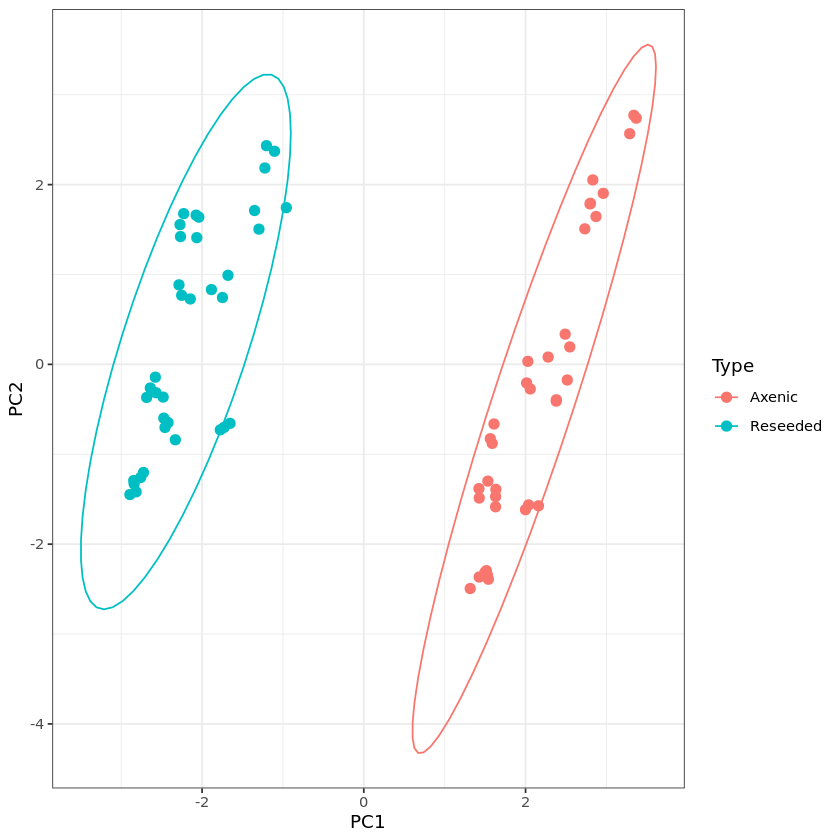

In [3]:
pc <- pca(d_mtab_numeric_log, center = TRUE, scale = "vector", method="svd")
mtab.df <- merge(d_meta, scores(pc), by=0, sort=FALSE)
head(mtab.df)
ggplot(mtab.df, aes(PC1, PC2, color=Type)) + geom_point(size = 2.5) + stat_ellipse() + theme_bw()

I'll also export this data into a more useful format

In [5]:
pdf(file = "../output/metabolomics/PCA_axenic_v_reseeded.pdf")
ggplot(mtab.df, aes(PC1, PC2, color=Type)) + geom_point(size = 2.5) + stat_ellipse() + theme_bw()
dev.off()

png 
  2

Next, I'll split the data (both LCMS data and metadata) by reseeded and axenic samples, to generate figures 2b and 2c. Ultimately my data splitting was via a pretty low tech solution, totally failed to get tidyverse-based approaches to work

In [6]:
dim(d_mtab_numeric_log)
d_mtab_reseeded <- d_mtab_numeric_log[c(1:36), c(1:1237)]
dim(d_mtab_reseeded)
#view(d_mtab_reseeded)

d_mtab_axenic <- d_mtab_numeric_log[c(37:72), c(1:1237)]
dim(d_mtab_axenic)
#view(d_mtab_axenic)

[1]   72 1237

[1]   36 1237

[1]   36 1237

In [7]:
dim(d_meta)
d_meta_reseeded <- d_meta[c(1:36), c(1:3)]
dim(d_meta_reseeded)
#view(d_meta_reseeded)

d_meta_axenic <- d_meta[c(37:72), c(1:3)]
dim(d_meta_axenic)
#view(d_meta_axenic)

[1] 72  3

[1] 36  3

[1] 36  3

Now make the PCA for each subset, colored by time

Warning message in prep(Matrix, scale = scale, center = center, simple = FALSE, :
“Variance is below eps for 4 variables. Not scaling them.”


,Row.names,Sample,Type,Time,PC1,PC2
,<I<chr>>,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,1,R1a_0.5h,Reseeded,0.5,-2.67566046,-1.0368665
2,2,R1b_0.5h,Reseeded,0.5,-2.61823811,-1.1246122
3,3,R1c_0.5h,Reseeded,0.5,-2.84890498,-0.9907118
4,4,R2a_0.5h,Reseeded,0.5,0.27103590,-3.9108934
5,5,R2b_0.5h,Reseeded,0.5,-0.10862434,-3.6580675
6,6,R2c_0.5h,Reseeded,0.5,0.01536551,-3.6276199


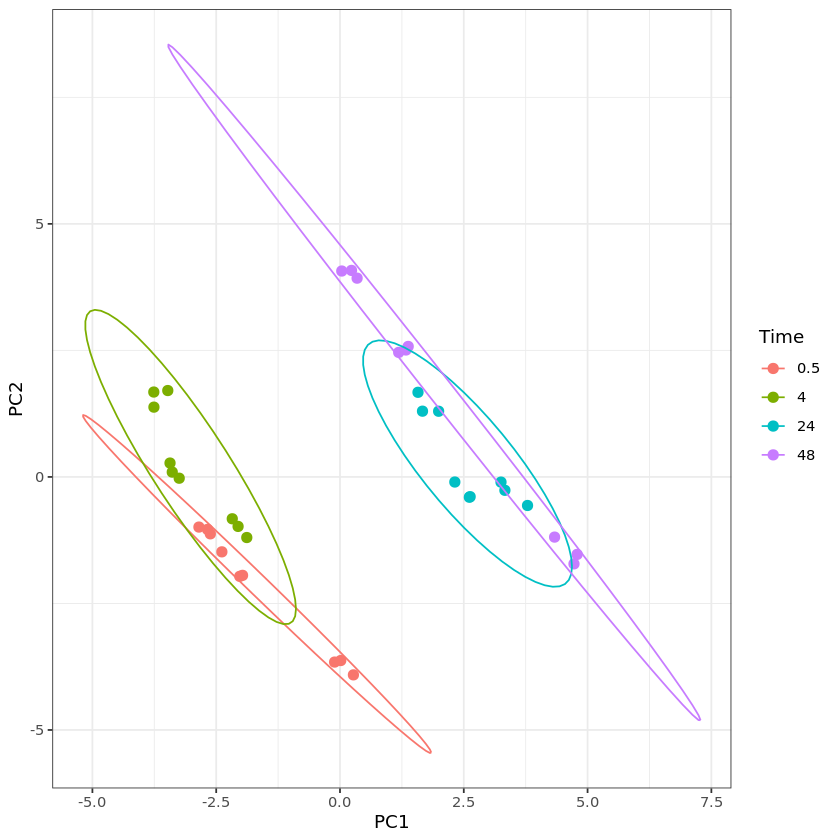

In [8]:
#PCA for reseeded samples

pc.reseeded <- pca(d_mtab_reseeded, center=TRUE, scale="vector")
reseeded.mtab.df <- merge(d_meta_reseeded, scores(pc.reseeded), by=0, sort=FALSE)
head(reseeded.mtab.df)
ggplot(reseeded.mtab.df, aes(PC1, PC2, color=Time)) + geom_point(size = 2.5) + stat_ellipse() + theme_bw()

Warning message in prep(Matrix, scale = scale, center = center, simple = FALSE, :
“Variance is below eps for 41 variables. Not scaling them.”


,Row.names,Sample,Type,Time,PC1,PC2
,<I<chr>>,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,37,A1a_0.5h,Axenic,0.5,-1.1589384,-2.972519
2,38,A1b_0.5h,Axenic,0.5,-0.9703185,-2.846897
3,39,A1c_0.5h,Axenic,0.5,-0.6990391,-2.816011
4,40,A2a_0.5h,Axenic,0.5,1.6997107,-1.984051
5,41,A2b_0.5h,Axenic,0.5,1.8681161,-1.975482
6,42,A2c_0.5h,Axenic,0.5,1.8796684,-2.100538


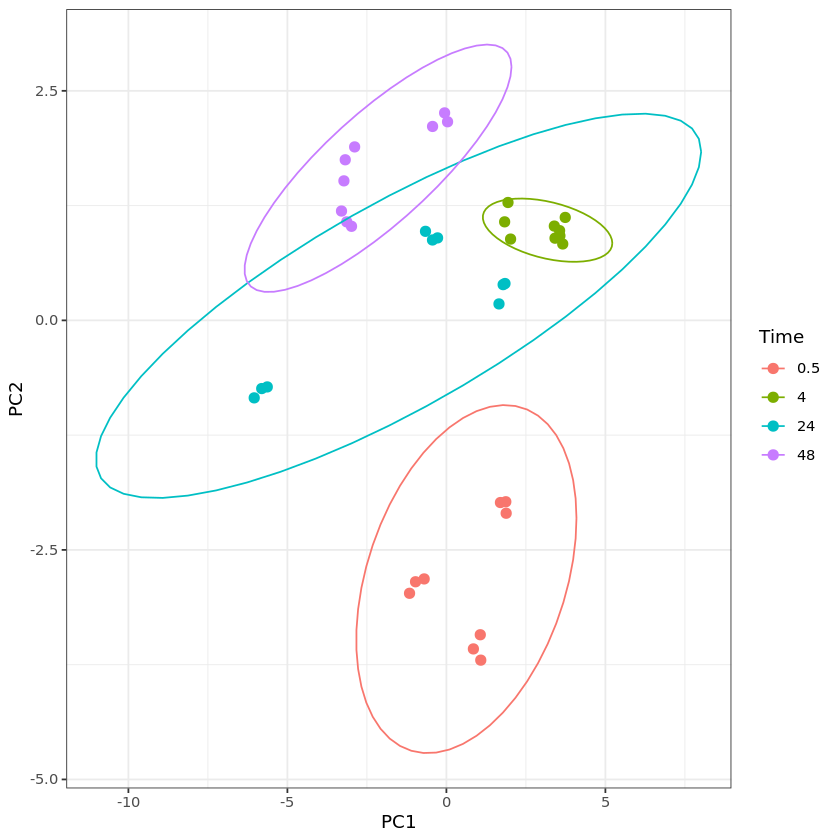

In [9]:
#PCA for axenic samples

pc.axenic <- pca(d_mtab_axenic, center=TRUE, scale="vector")
axenic.mtab.df <- merge(d_meta_axenic, scores(pc.axenic), by=0, sort=FALSE)
head(axenic.mtab.df)
ggplot(axenic.mtab.df, aes(PC1, PC2, color=Time)) + geom_point(size = 2.5) + stat_ellipse() + theme_bw()

And again, put files to output

In [12]:
pdf(file = "../output/metabolomics/PCA_reseeded_by_time.pdf")
ggplot(reseeded.mtab.df, aes(PC1, PC2, color=Time)) + geom_point(size = 2.5) + stat_ellipse() + theme_bw()
dev.off()

png 
  2

In [13]:
pdf(file = "../output/metabolomics/PCA_axenic_by_time.pdf")
ggplot(axenic.mtab.df, aes(PC1, PC2, color=Time)) + geom_point(size = 2.5) + stat_ellipse() + theme_bw()
dev.off()

png 
  2

### Mahalanobis distances

Finally, Mahalanobis distances were calculated based on the axenic and reseeded PCA plots. Very little direction was given here by the authors, so I went with something that I could get to work. 

For the first set (axenic samples), I also check and make sure having metadata in my dataframe doesn't mess with the Mahalanobis distance calculation - it looks OK to me

In [14]:
subset.axenic.for.maha <- axenic.mtab.df[c(1:36), c(5:6)]
axenic.mahalanobis <- mahalanobis_distance(axenic.mtab.df)
axenic.mahalanobis.alt <- mahalanobis_distance(subset.axenic.for.maha)
head(axenic.mahalanobis)
head(axenic.mahalanobis.alt)
mean(axenic.mahalanobis$mahal.dist)
mean(axenic.mahalanobis.alt$mahal.dist)

,PC1,PC2,mahal.dist,is.outlier
,<dbl>,<dbl>,<dbl>,<lgl>
1,-1.1589384,-2.972519,2.838,FALSE
2,-0.9703185,-2.846897,2.566,FALSE
3,-0.6990391,-2.816011,2.455,FALSE
4,1.6997107,-1.984051,1.558,FALSE
5,1.8681161,-1.975482,1.624,FALSE
6,1.8796684,-2.100538,1.784,FALSE


,PC1,PC2,mahal.dist,is.outlier
,<dbl>,<dbl>,<dbl>,<lgl>
1,-1.1589384,-2.972519,2.838,FALSE
2,-0.9703185,-2.846897,2.566,FALSE
3,-0.6990391,-2.816011,2.455,FALSE
4,1.6997107,-1.984051,1.558,FALSE
5,1.8681161,-1.975482,1.624,FALSE
6,1.8796684,-2.100538,1.784,FALSE


[1] 1.9445

[1] 1.9445

In [15]:
#Now reseeded samples

reseeded.mahalanobis <- mahalanobis_distance(reseeded.mtab.df)
head(reseeded.mahalanobis)
mean(reseeded.mahalanobis$mahal.dist)

,PC1,PC2,mahal.dist,is.outlier
,<dbl>,<dbl>,<dbl>,<lgl>
1,-2.67566046,-1.0368665,1.234,FALSE
2,-2.61823811,-1.1246122,1.238,FALSE
3,-2.84890498,-0.9907118,1.342,FALSE
4,0.27103590,-3.9108934,3.652,FALSE
5,-0.10862434,-3.6580675,3.188,FALSE
6,0.01536551,-3.6276199,3.133,FALSE


[1] 1.944444

### Analysis

This isn't too bad! Without the underlying principle component data of the figures the authors created, it's hard to evaluate quantitatively the difference between these figure and the authors' PCAs, but they at least appear fairly similar. The scale on my PC axes are different, and the graphs are mirrored relative to the published figures, but qualitatively these results are similar, and reflect differences in the exometabolome and activity of axenic diatom cultures vs. diatom cultures reseeded with their bacterial consortia. 

The differences between these figures and the published figures 2a-c could be due to several factors: the authors normalized to sample volume, which we can't do, and the use of a different program for generating PCAs may have led to different underlying parameters. The authors didn't specify any parameters in the generation of their PCAs, beyond the log10 normalization and unspecified scaling, which makes this a bit of a black box. 

Mahalanobis distances are one way we can evaluate our results to the authors' a bit more quanititatively. Our calculated Mahalanobis distances are smaller than the authors', and again probably reflect the lack of clarity around how those distances were calculated in the original paper, or additional normalization that we do not have the ability to do. 

## Evaluating the heatmap (Figure 2d)

In figure 2d, Shibl and colleagues present a heatmap of "confirmed" metabolites, color-coded by their intensity. The data underlying this figure is split between tables: one, the same data table used to generate figures 2a-c which contains a list of mzRTs and their intensity across all samples; and two, the table of mass (M (Da)), retention time (RT), and compound identity. Therefore, as a first step towards making the heatmap, I'll need to match plausible sample mzRTs to the standard m/z's and RTs. In order to be a match, a sample mzRT must match the standard m/z within reasonable error (more details below) and match the standard RT within ~seconds, not ~minutes

As with the PCAs, these data underwent some manual manipulation prior to analysis, which is described in the README. 

### Start with data download:

In [25]:
mtab_data <- "../data/clean_data/metabolome/Dataset_S01_edit.csv"
d_mtab <- read.table(mtab_data, header = TRUE, sep = ",", stringsAsFactors = FALSE)
dim(d_mtab)
#Below data transformations not really relevant for this project
#d_mtab_numeric <- d_mtab[c(1:72), c(2:1238)]
#d_mtab_numeric_log <- mutate(log10(d_mtab_numeric + 1))

mtab_ID <- "../data/clean_data/metabolome/Table_S4.csv"
d_ID <- read.table(mtab_ID, header = TRUE, sep = ",", stringsAsFactors = FALSE)
head(d_ID)

[1] 1237   74

,M..Da.,RT..min.,Adduct,Name,Calculated.m.z,RT..s.
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,103.0622,19.94,[4M+H]+,4-Aminobutanoate,413.25662,1196.4
2,117.0780,0.45,[M+H+H]2+,Norvaline,59.54682,27.0
3,119.0578,12.42,[M+H]+,Threonine,120.06562,745.2
4,122.0369,10.25,[M+H]+,4-Hydroxybenzaldehyde,123.04472,615.0
5,131.0946,13.51,[M+H]+,Leucine,132.10243,810.6
6,136.0511,19.91,[M+H]+,Phenylacetic acid,137.05892,1194.6


### Next, set m/z ranges that reflect reasonable error tolerances

There are several possible reasonable error tolerances. Your error tolerance could be determined by the precision required for unambiguous formula assignments (0.0001 Da); by the reported instrumental accuracy for the instrument which generated these data (1 ppm, according to Bruker's advertising); or by other prior knowledge (e,g,, when I'm looking for a compound in chromatograms I generate for work, I extract for a m/z using a 5 ppm tolerance - so I consider 5 ppm to be a reasonable error threshold)

In [26]:
#Select desired error tolerance - in order, 0.0001 Da; 1ppm; or 5ppm. Uncomment relevant line. Default is most tolerant - 5 ppm

#d_ID$error <- 0.0001
#d_ID$error <- d_ID$Calculated.m.z*(1E-6)
d_ID$error <- d_ID$Calculated.m.z*(5E-6)

d_ID$m.z.low <- d_ID$Calculated.m.z - d_ID$error
d_ID$m.z.high <- d_ID$Calculated.m.z + d_ID$error

head(d_ID)

,M..Da.,RT..min.,Adduct,Name,Calculated.m.z,RT..s.,error,m.z.low,m.z.high
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,103.0622,19.94,[4M+H]+,4-Aminobutanoate,413.25662,1196.4,0.0020662831,413.25456,413.25869
2,117.0780,0.45,[M+H+H]2+,Norvaline,59.54682,27.0,0.0002977341,59.54653,59.54712
3,119.0578,12.42,[M+H]+,Threonine,120.06562,745.2,0.0006003281,120.06502,120.06623
4,122.0369,10.25,[M+H]+,4-Hydroxybenzaldehyde,123.04472,615.0,0.0006152236,123.04411,123.04534
5,131.0946,13.51,[M+H]+,Leucine,132.10243,810.6,0.0006605121,132.10176,132.10309
6,136.0511,19.91,[M+H]+,Phenylacetic acid,137.05892,1194.6,0.0006852946,137.05824,137.05961


Filter out intensity data from mzRT + intensity table - intensity is not relevant yet

In [27]:
d_mzRT <- d_mtab[c(1:1237), c(1:2)]

### Try a way of matching "identified" compounds against sample mzRTs

I'm pretty sure this is bad R and I should have tried this in a different language (literally anything else) with a for loop but I'm hacking it like this regardless. Sorry for the wildly inelegant solution!

Here, I'm checking each sample m/z listed against the relevant m/z range for each metabolite reported as "confirmed" by Shibl et al. I generate a new column in my sample dataframe for each metabolite; that column contains a logical operator, where "TRUE" means that mzRT is a reasonable match for the "confirmed" metabolite represented by that column. I then count the instances of "TRUE" to evaluate if a reasonable m/z match for the reported "confirmed" metabolite is present in the sample data. 

In [28]:
d_mzRT$aminobenzoate <- between(d_mzRT$m.z..positive.mode., d_ID[1,8], d_ID[1,9])
length(d_mzRT$aminobenzoate[d_mzRT$aminobenzoate==TRUE])

d_mzRT$Norvaline <- between(d_mzRT$m.z..positive.mode., d_ID[2,8], d_ID[2,9])
length(d_mzRT$Norvaline[d_mzRT$Norvaline==TRUE])

d_mzRT$Threonine <- between(d_mzRT$m.z..positive.mode., d_ID[3,8], d_ID[3,9])
length(d_mzRT$Threonine[d_mzRT$Threonine==TRUE])

d_mzRT$Hydroxybenzaldehyde <- between(d_mzRT$m.z..positive.mode., d_ID[4,8], d_ID[4,9])
length(d_mzRT$Hydroxybenzaldehyde[d_mzRT$Hydroxybenzaldehyde==TRUE])

d_mzRT$Leucine <- between(d_mzRT$m.z..positive.mode., d_ID[5,8], d_ID[5,9])
length(d_mzRT$Leucine[d_mzRT$Leucine==TRUE])

d_mzRT$Phenylacetic <- between(d_mzRT$m.z..positive.mode., d_ID[6,8], d_ID[6,9])
length(d_mzRT$Phenylacetic[d_mzRT$Phenylacetic==TRUE])

d_mzRT$Phenyl <- between(d_mzRT$m.z..positive.mode., d_ID[7,8], d_ID[7,9])
length(d_mzRT$Phenyl[d_mzRT$Phenyl==TRUE])

d_mzRT$Salicylic <- between(d_mzRT$m.z..positive.mode., d_ID[8,8], d_ID[8,9])
length(d_mzRT$Salicylic[d_mzRT$Salicylic==TRUE])

d_mzRT$Acetamidobutanoic <- between(d_mzRT$m.z..positive.mode., d_ID[9,8], d_ID[9,9])
length(d_mzRT$Acetamidobutanoic[d_mzRT$Acetamidobutanoic==TRUE])

d_mzRT$Methyglutaric <- between(d_mzRT$m.z..positive.mode., d_ID[10,8], d_ID[10,9])
length(d_mzRT$Methyglutaric[d_mzRT$Methyglutaric==TRUE])

d_mzRT$Hydroxyphenylacetate <- between(d_mzRT$m.z..positive.mode., d_ID[11,8], d_ID[11,9])
length(d_mzRT$Hydroxyphenylacetate[d_mzRT$Hydroxyphenylacetate==TRUE])

d_mzRT$Aminoadipate <- between(d_mzRT$m.z..positive.mode., d_ID[12,8], d_ID[12,9])
length(d_mzRT$Aminoadipate[d_mzRT$Aminoadipate==TRUE])

d_mzRT$Hydroxyphenylglycine <- between(d_mzRT$m.z..positive.mode., d_ID[13,8], d_ID[13,9])
length(d_mzRT$Hydroxyphenylglycine[d_mzRT$Hydroxyphenylglycine==TRUE])

d_mzRT$Methylhistidine <- between(d_mzRT$m.z..positive.mode., d_ID[14,8], d_ID[14,9])
length(d_mzRT$Methylhistidine[d_mzRT$Methylhistidine==TRUE])

d_mzRT$Quinolinecarboxylic <- between(d_mzRT$m.z..positive.mode., d_ID[15,8], d_ID[15,9])
length(d_mzRT$Quinolinecarboxylic[d_mzRT$Quinolinecarboxylic==TRUE])

d_mzRT$Suberic <- between(d_mzRT$m.z..positive.mode., d_ID[16,8], d_ID[16,9])
length(d_mzRT$Suberic[d_mzRT$Suberic==TRUE])

d_mzRT$Citrulline <- between(d_mzRT$m.z..positive.mode., d_ID[17,8], d_ID[17,9])
length(d_mzRT$Citrulline[d_mzRT$Citrulline==TRUE])

d_mzRT$Hippurate <- between(d_mzRT$m.z..positive.mode., d_ID[18,8], d_ID[18,9])
length(d_mzRT$Hippurate[d_mzRT$Hippurate==TRUE])

d_mzRT$Phosphoglyceric <- between(d_mzRT$m.z..positive.mode., d_ID[19,8], d_ID[19,9])
length(d_mzRT$Phosphoglyceric[d_mzRT$Phosphoglyceric==TRUE])

d_mzRT$Azelaic <- between(d_mzRT$m.z..positive.mode., d_ID[20,8], d_ID[20,9])
length(d_mzRT$Azelaic[d_mzRT$Azelaic==TRUE])

d_mzRT$Nacetylgalactosamine <- between(d_mzRT$m.z..positive.mode., d_ID[21,8], d_ID[21,9])
length(d_mzRT$Nacetylgalactosamine[d_mzRT$Nacetylgalactosamine==TRUE])

d_mzRT$Carnosine <- between(d_mzRT$m.z..positive.mode., d_ID[22,8], d_ID[22,9])
length(d_mzRT$Carnosine[d_mzRT$Carnosine==TRUE])

d_mzRT$Oleic <- between(d_mzRT$m.z..positive.mode., d_ID[23,8], d_ID[23,9])
length(d_mzRT$Oleic[d_mzRT$Oleic==TRUE])

d_mzRT$Stearic <- between(d_mzRT$m.z..positive.mode., d_ID[24,8], d_ID[24,9])
length(d_mzRT$Stearic[d_mzRT$Stearic==TRUE])

d_mzRT$Sphinganine <- between(d_mzRT$m.z..positive.mode., d_ID[25,8], d_ID[25,9])
length(d_mzRT$Sphinganine[d_mzRT$Sphinganine==TRUE])

d_mzRT$NTetradecanoylaspartic <- between(d_mzRT$m.z..positive.mode., d_ID[26,8], d_ID[26,9])
length(d_mzRT$NTetradecanoylaspartic[d_mzRT$NTetradecanoylaspartic==TRUE])

d_mzRT$Rosmarinic <- between(d_mzRT$m.z..positive.mode., d_ID[27,8], d_ID[27,9])
length(d_mzRT$Rosmarinic[d_mzRT$Rosmarinic==TRUE])

d_mzRT$glycerophosphocholine <- between(d_mzRT$m.z..positive.mode., d_ID[28,8], d_ID[28,9])
length(d_mzRT$glycerophosphocholine[d_mzRT$glycerophosphocholine==TRUE])

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 3

[1] 0

[1] 0

This tells me that there is only one identified compound in the "d_ID" table that has matches in the "d_mzRT" table, and that there are three mzRTs that have an mzRT within error of that compound. That compound is "NTetradecanoylaspartic" (actual name N-Tetradecanoylaspartic acid). Now, of those three, let's see if there is a RT with a reasonable match

## Filter for possible N-Tetradecanoylaspartic acid matches

In [29]:
d_mzRT_Ntetradecanoylaspartic <- filter(d_mzRT, d_mzRT$NTetradecanoylaspartic==TRUE)

## Compare retention times

I again apologize for the inelegant solution, but there's literally only one compound to look for out of only 28 compounds, so I've used a low-tech approach to find the retention time for identified N-Tetradecanoylaspartic acid

In [31]:
dim(d_ID)

[1] 28  9

In [32]:
print(d_ID[c(23:28), c(1:9)])

     M..Da. RT..min.  Adduct                              Name Calculated.m.z
23 282.2556    17.01 [M-H]-                         Oleic acid       281.2478
24 284.2709    18.17 [M-H]-                       Stearic acid       283.2631
25 301.2980    10.46  [M+H]+                       Sphinganine       302.3058
26 342.2278    15.50  [M+H]+      N-Tetradecanoylaspartic acid       343.2356
27 360.0843    18.77 [M+H]+                    Rosmarinic acid       361.0921
28 541.3372    16.60 [M-H]-  C16-hydroxy-glycerophosphocholine       540.3294
   RT..s.       error  m.z.low m.z.high
23 1020.6 0.001406239 281.2464 281.2492
24 1090.2 0.001416315 283.2617 283.2645
25  627.6 0.001511529 302.3043 302.3073
26  930.0 0.001716178 343.2339 343.2373
27 1126.2 0.001805461 361.0903 361.0939
28  996.0 0.002701647 540.3267 540.3321


This gives the RT for the N-tetradecanoylaspartic acid standard as 930.0 seconds

Now, calculate the difference between sample RT and standard RT for the sample mzRTs which could (by mz) be N-Tttradecanoylaspartic acid

In [33]:
d_mzRT_Ntetradecanoylaspartic$RT_diff_min <- (d_mzRT_Ntetradecanoylaspartic$RT - 930.0)/60
print(d_mzRT_Ntetradecanoylaspartic$RT_diff_min)

[1] -10.183500  -4.920167 -10.115167


All of the possible compounds to match N-tetradecanoylaspartic acid by m/z have a difference in retention time of at least 4.9 minutes - these cannot be the same compound. 

So, in summary: 
 - Shibl et al. claimed to have identified 28 compounds that went into their heatmap
 - Of those 28, using a relatively liberal error of 5 ppm, 27 did not have a matching m/z in the available mzRT+intensity data
 - One of the "identified" compounds, N-tetradecanoylaspartic acid, had matches in the available mzRT+intensity data. However none of those matches had a retention time close to Shibl et al.'s N-tetradecanoylaspartic acid standard; therefore these mzRTs cannot be the same compound
 - 0 of the compounds reported as "identified" by Shibl et al. can be found in the available mzRT+intensity data

png 
  2

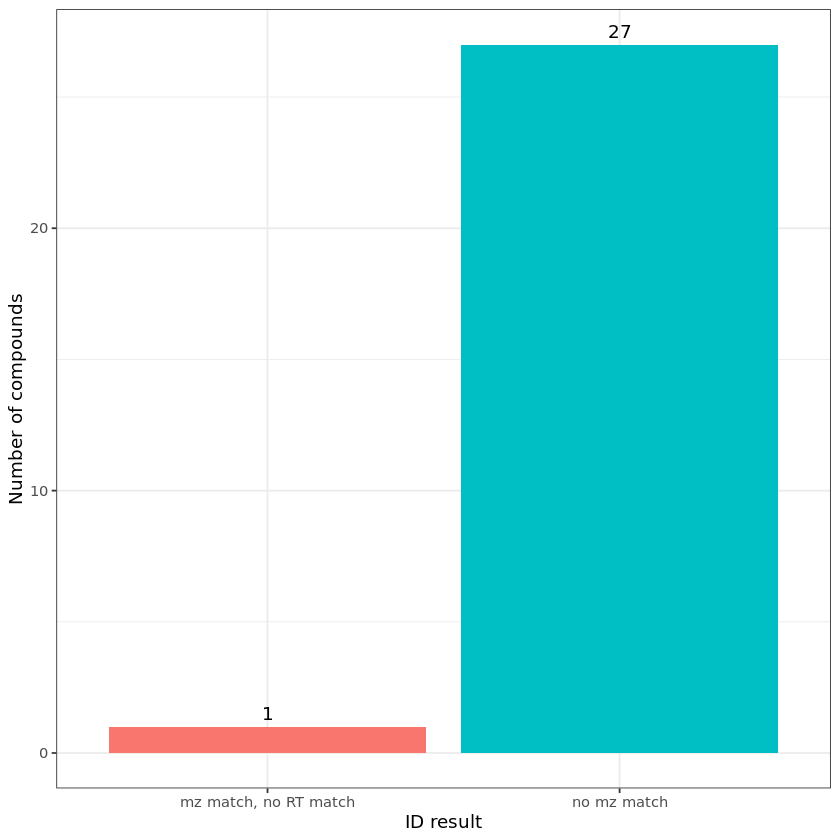

In [34]:
##Plot this

ID_result <- c('no mz match', 'mz match, no RT match')
num_compounds <- c(27, 1)
mzRT_results <- data.frame(ID_result, num_compounds)

plot <- ggplot(mzRT_results, aes(x = ID_result, y = num_compounds, fill = ID_result))
plot + geom_col(show.legend = FALSE) + theme_bw() + geom_text(aes(label=num_compounds), vjust= -0.5) + ylab("Number of compounds") + xlab("ID result")

pdf(file = "../output/metabolomics/mzRT_match_results.pdf")
plot + geom_col(show.legend = FALSE) + theme_bw() + geom_text(aes(label=num_compounds), vjust= -0.5) + ylab("Number of compounds") + xlab("ID result")
dev.off()

This is a pretty incredible degree of irreproducibility! I expected that the heatmap might look different, but also I expected that the compounds the authors said were in their data would actually be there. I checked my work manually, and checked with the rest of the Kujawmiski lab, and I don't believe that the mistake is in my processing. It's possible that the "identified" compounds didn't make it into Dataset_S01, although this would be contrary to the authors' words in other parts of the paper. There's no good explanation for what I've found here.  

## Generate nonsensical heatmap

Because the "confirmed" metabolites from Shibl et al. cannot be found in the list of sample mzRTs, generating a heatmap is a bit nonsensical. Regardless, this script is intended to be a quick exploration into how generating a heatmap would work, if I had relevant and reliable data. 

First, grab the data; ComplexHeatmap prefers only numeric data, so trim dataframe accordingly

In [35]:
mtab_data <- "../data/clean_data/metabolome/Dataset_S01_edit_3_R.csv"
d_mtab <- read.table(mtab_data, header = FALSE, sep = ",", stringsAsFactors = FALSE)
d_mtab_heatmap <- d_mtab[c(1:72), c(2:1238)]

Now make a heatmap!

png 
  2

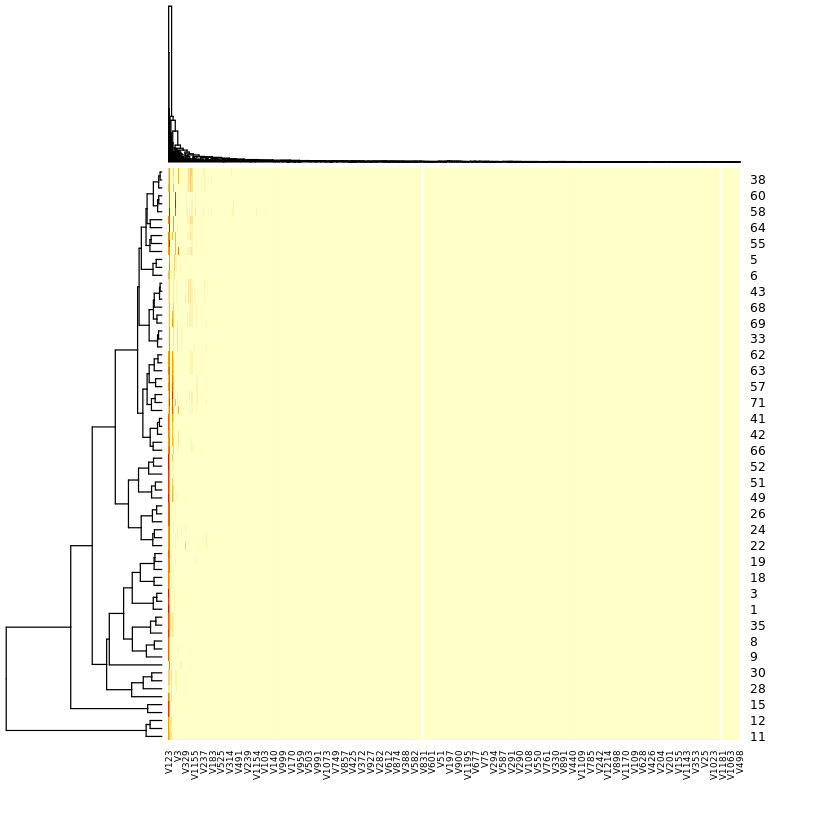

In [36]:
d_mtab_heatmap <- data.matrix(d_mtab_heatmap)
pdf(file = "../output/metabolomics/heatmap_1.pdf")
heatmap(d_mtab_heatmap)
dev.off()
heatmap(d_mtab_heatmap)

This obviously looks very different from the heatmap that the authors presented, as you might expect from a heatmap generated with a dramatically different list of compounds. 